In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

In [115]:
df_org = pd.read_excel("Incidents.xlsx")
df_org["ttr_days"]=df_org["am_ttr"]/3600/24
df_org["ttr_days"]=df_org["global_ttr_seconds"]/3600/24
df_org.drop(columns=["am_ttr"], inplace=True)
df_org.drop(columns=["global_ttr_seconds"], inplace=True)

In [142]:
# Fill numeric columns with the mean (limited to csat_score)
# num_vars = df_org.select_dtypes(include=['float', 'int']).columns
# for col in num_vars:
#     df_org[col].fillna((df_org[col].mean()), inplace=True)

# Dummy the categorical variables
cat_vars = ["reopened_flag","appl_tier","priority","contact_type","team","inc_close_code"]
df_org = df_org.apply(lambda x: x.mask(x.map(x.value_counts())<20, 'other') if x.name in cat_vars else x)

for var in  cat_vars:
    df_org = pd.concat([df_org, pd.get_dummies(df_org[var], prefix=var, prefix_sep='#', drop_first=True, dummy_na=False)], axis=1)

In [143]:
df = df_org[df_org["ttr_days"]<df_org["ttr_days"].quantile(0.95)]

X_cols = [col for col in df.columns if '#' in col]
X = df[X_cols]

y = df['ttr_days']


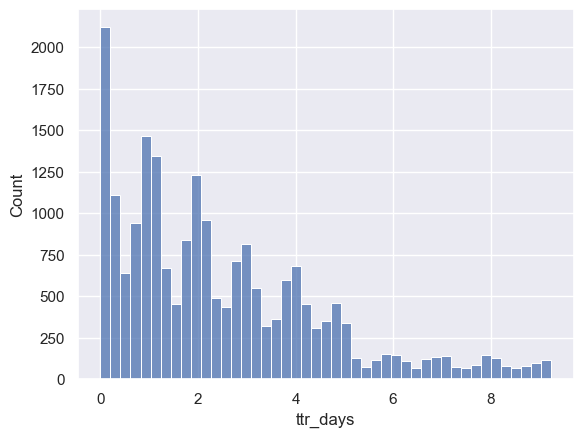

In [146]:
sns.set(style="darkgrid")
sns.histplot(data=df,x="ttr_days")
plt.show()

In [147]:
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit

#Predict using your model
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)
y_preds = lm_model.predict(X)

#Score using your model
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)
overall_score = r2_score(y, y_preds)

print("The rsquared on the training data was {:.3f}.  The rsquared on the test data was {:.3f}. Overall rsquared {:.3f}".format(train_score, test_score, overall_score))



The rsquared on the training data was 0.260.  The rsquared on the test data was 0.255. Overall rsquared 0.259


In [148]:
X1 = df_org[X_cols]
df_org["pred"] = lm_model.predict(X1)



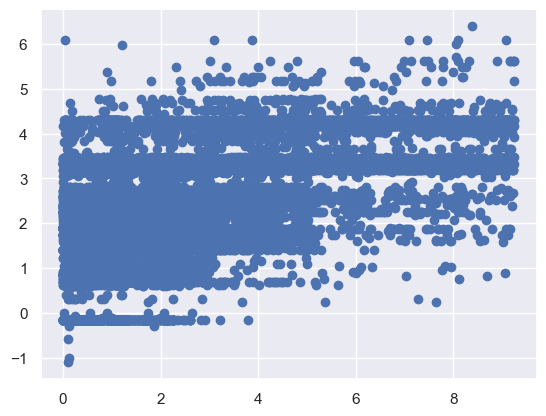

In [149]:
plt.scatter(y,y_preds)
plt.show()


In [150]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df = coefs_df.sort_values('coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.to_excel("IncidentDuration_coef.xlsx")

In [151]:
df_org["diff"] = df_org["ttr_days"]-df_org["pred"]